<a href="https://colab.research.google.com/github/Kirk-KD/caries-segmentation/blob/master/caries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import detectron2
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader, DatasetMapper
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
import matplotlib.pyplot as plt
from collections import Counter
import torch
import os
import random
import numpy as np
from PIL import Image
from detectron2.utils.visualizer import Visualizer
from torch.utils.data import WeightedRandomSampler
import json
import cv2

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-pw_eotar
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-pw_eotar
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataset_root = "/content/drive/MyDrive/Colab Notebooks/Dental Caries Lesion Stages/caries-dataset"
class_names = ["caries-enamel", "caries-dentin", "caries-pulp"]
splits = ["train", "test", "valid"]

# Clean data

The original data contained some unused and garbled class names, which have already been removed manually. The following cell addresses the misalignment of the remaining class ID mapping.

Originally, the mapping was:
- 3 = dentin
- 4 = enamel
- 5 = pulp

For the sake of clarity, we will use the following code to generate `_annotations_clean.coco.json` in each of `train`, `valid`, and `test`, from `_annotations.coco.json`, with the new mapping:
- 1 = enamel
- 2 = dentin
- 3 = pulp

The new mapping will respect detectron2's expected ID range of `[1, #categories]`, and reflect the layers of tooth from the outside in.

This also means the annotation classes must be changed for each image too, with the following change map:
- 3 -> 2
- 4 -> 1
- 5 -> 3

In [3]:
change_map = {
    3: 2,
    4: 1,
    5: 3
}

for folder in splits:
    with open(f"{dataset_root}/{folder}/_annotations.coco.json", "r") as f:
        data = json.load(f)

    data["categories"] = [
        {
            "id": 1,
            "name": "caries-enamel",
            "supercategory": "caries-z1wh"
        },
        {
            "id": 2,
            "name": "caries-dentin",
            "supercategory": "caries-z1wh"
        },
        {
            "id": 3,
            "name": "caries-pulp",
            "supercategory": "caries-z1wh"
        }
    ]

    for ann in data["annotations"]:
        ann["category_id"] = change_map[ann["category_id"]]

    with open(f"{dataset_root}/{folder}/_annotations_clean.coco.json", "w") as f:
        json.dump(data, f)

After data is cleaned and remapped, we can now load from `_annotations_clean.coco.json` of each folder.

In [4]:
for folder in splits:
    register_coco_instances(folder, {}, f"{dataset_root}/{folder}/_annotations_clean.coco.json", f"{dataset_root}/{folder}")

# Config

In [5]:
# config
cfg = get_cfg()
YAML = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(YAML))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(YAML)
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("valid",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.DEVICE = "cuda"

# hyperparameters
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.STEPS = [2000, 2500]
cfg.SOLVER.GAMMA = 0.5
cfg.TEST.EVAL_PERIOD = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05

# output
cfg.OUTPUT_DIR = "/content/caries-output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Exploration

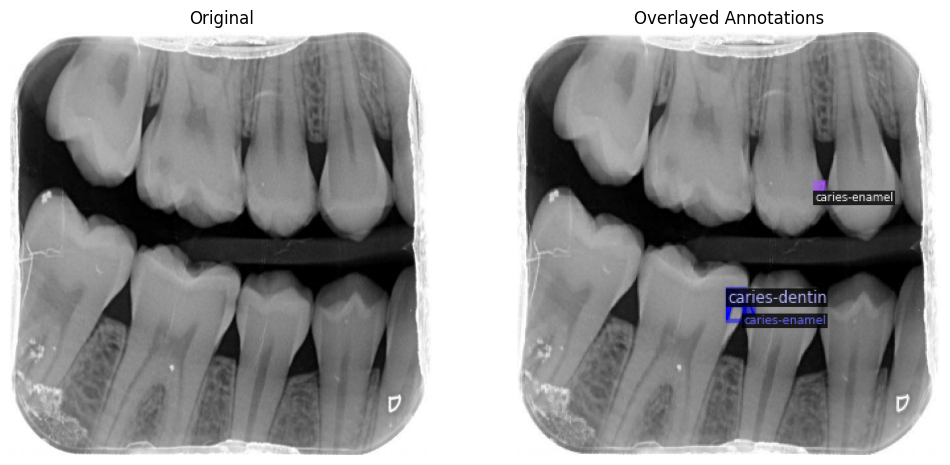

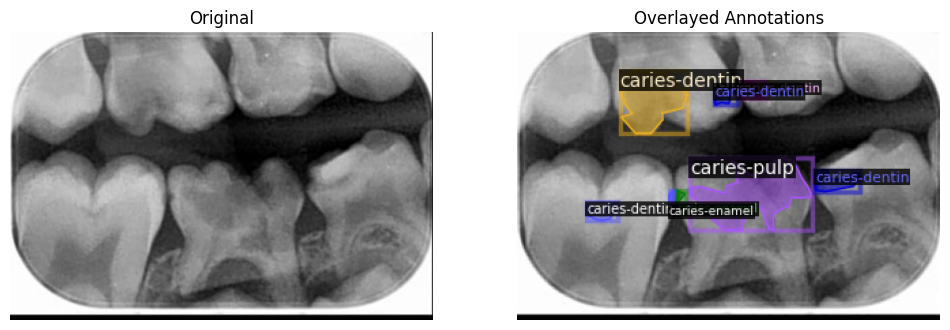

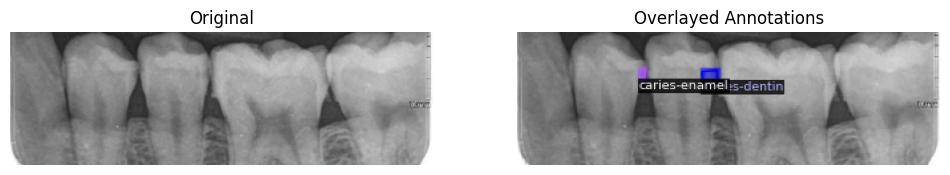

In [6]:
train_data = DatasetCatalog.get("train")
train_meta = MetadataCatalog.get("train")

for d in random.sample(train_data, 3):
    img = np.array(Image.open(d["file_name"]).convert("RGB"))

    visualizer = Visualizer(img, metadata=train_meta, scale=0.5)
    vis = visualizer.draw_dataset_dict(d).get_image()

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(img)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(vis)
    ax[1].set_title("Overlayed Annotations")
    ax[1].axis("off")

    plt.show()

Number of training samples: 1217
Number of validation samples: 347
Number of evaluation samples: 152
Train frequencies:
caries-enamel: 0.43
caries-dentin: 0.50
caries-pulp: 0.07


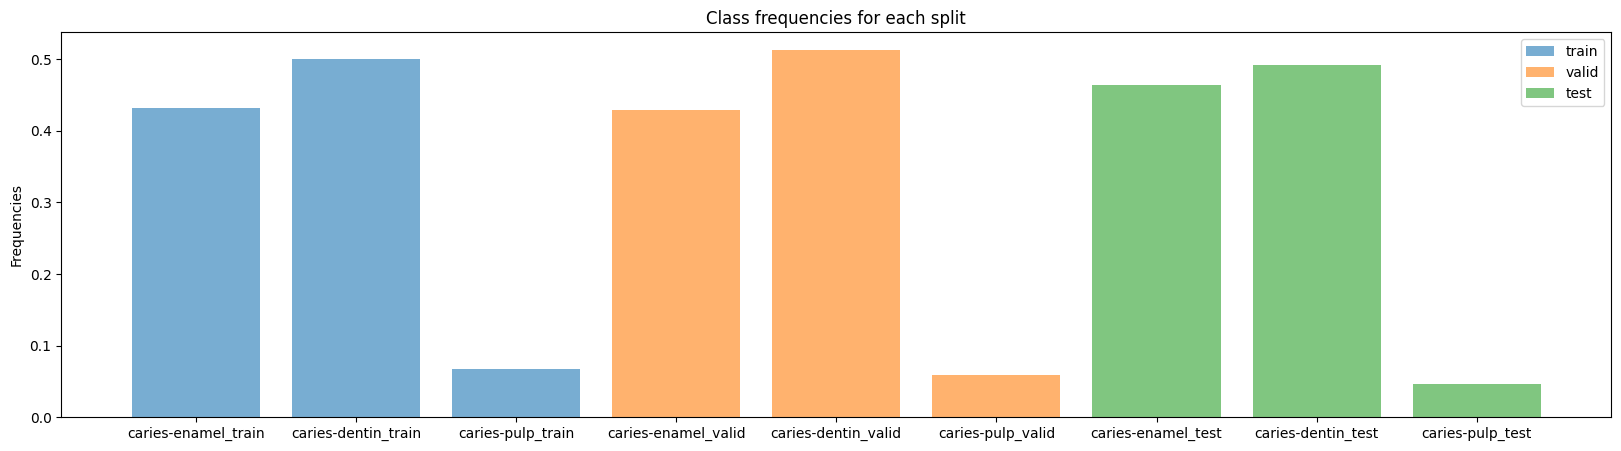

In [7]:
data_train = DatasetCatalog.get("train")  # training
data_valid = DatasetCatalog.get("valid")  # validation
data_test = DatasetCatalog.get("test")    # evaluation

print(f"Number of training samples: {len(data_train)}")
print(f"Number of validation samples: {len(data_valid)}")
print(f"Number of evaluation samples: {len(data_test)}")

def get_class_frequencies(dataset):
    counts = Counter()
    for item in dataset:
        for ann in item['annotations']:
            counts[ann['category_id']] += 1
    total = sum(counts.values())
    freqs = {k: v/total for k, v in counts.items()}
    return freqs

train_freqs = get_class_frequencies(data_train)
valid_freqs = get_class_frequencies(data_valid)
test_freqs  = get_class_frequencies(data_test)

classes = sorted(train_freqs.keys())
print("Train frequencies:")
for c in classes:
    print(f"{class_names[c]}: {train_freqs[c]:.2f}")

plt.figure(figsize=(20,5))
plt.bar([class_names[c]+'_train' for c in classes], [train_freqs[c] for c in classes], alpha=0.6, label='train')
plt.bar([class_names[c]+'_valid' for c in classes], [valid_freqs[c] for c in classes], alpha=0.6, label='valid')
plt.bar([class_names[c]+'_test' for c in classes], [test_freqs[c] for c in classes], alpha=0.6, label='test')
plt.ylabel("Frequencies")
plt.title("Class frequencies for each split")
plt.legend()
plt.show()

We notice severe class imbalance of `caries-pulp` (7%).

# Addressing class imbalance

Here we will use per-image oversampling by a factor of 5 for class `caries-pulp`.

In [8]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        data_train = DatasetCatalog.get("train")

        weights = []
        for d in data_train:
            cat_ids = [ann['category_id'] for ann in d['annotations']]
            weights.append(5.0 if 2 in cat_ids else 1.0)  # class index 2 = caries-pulp

        n_samples = cfg.SOLVER.IMS_PER_BATCH * cfg.SOLVER.MAX_ITER * 2  # times 2 for safety
        sampler = WeightedRandomSampler(weights, num_samples=n_samples, replacement=True)

        return build_detection_train_loader(cfg, sampler=sampler)

try:
  trainer = MyTrainer(cfg)
except RuntimeError:
  cfg.MODEL.DEVICE = "cpu"
  trainer = MyTrainer(cfg)

[09/13 02:38:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Check new class frequencies:

[09/13 02:38:46 d2.data.datasets.coco]: Loaded 1217 images in COCO format from /content/drive/MyDrive/Colab Notebooks/Dental Caries Lesion Stages/caries-dataset/train/_annotations_clean.coco.json
[09/13 02:38:46 d2.data.datasets.coco]: Loaded 1217 images in COCO format from /content/drive/MyDrive/Colab Notebooks/Dental Caries Lesion Stages/caries-dataset/train/_annotations_clean.coco.json
[09/13 02:38:47 d2.data.build]: Removed 0 images with no usable annotations. 1217 images left.
[09/13 02:38:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/13 02:38:47 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/13 02:38:47 d2.data.common]: Serializing 1217 elements to byte tensors and concatenating them all ...
[09/13 02:38:47 d2.data.common]: Serialized dataset takes 1.15 MiB
[09/13 02:

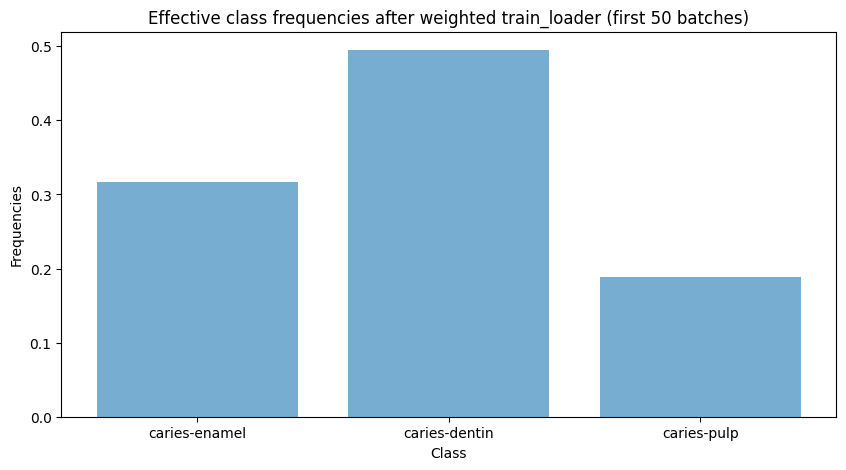

In [9]:
# count classes in the first N batches
counter = Counter()
N_batches = 50
for i, batch in enumerate(trainer.build_train_loader(cfg)):
    for sample in batch:
        anns = sample["instances"].gt_classes
        counter.update(anns.tolist())
    if i >= N_batches - 1:
        break

total = sum(counter.values())
classes = sorted(counter.keys())
frequencies = [counter[c]/total for c in classes]
print("Train frequencies:")
for c in classes:
    print(f"{class_names[c]}: {frequencies[c]:.2f}")

plt.figure(figsize=(10,5))
plt.bar([class_names[c] for c in classes], frequencies, alpha=0.6)
plt.ylabel("Frequencies")
plt.xlabel("Class")
plt.title(f"Effective class frequencies after weighted train_loader (first {N_batches} batches)")
plt.show()


After balancing, previously severely underrepresented class `caries-pulp` is resampled from around 7% to around 20%.

# Train

In [10]:
cfg.DATASETS.TEST = ("valid",)
trainer.resume_or_load(resume=False)
trainer.train()

[09/13 02:38:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[09/13 02:38:58 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/13 02:39:20 d2.utils.events]:  eta: 0:51:22  iter: 19  total_loss: 2.721  loss_cls: 1.363  loss_box_reg: 0.09112  loss_mask: 0.6928  loss_rpn_cls: 0.5461  loss_rpn_loc: 0.03967    time: 0.9809  last_time: 1.0781  data_time: 0.0575  last_data_time: 0.0124   lr: 4.9953e-06  max_mem: 4898M
[09/13 02:39:44 d2.utils.events]:  eta: 0:50:53  iter: 39  total_loss: 2.612  loss_cls: 1.205  loss_box_reg: 0.08261  loss_mask: 0.6921  loss_rpn_cls: 0.5681  loss_rpn_loc: 0.0413    time: 0.9679  last_time: 1.1441  data_time: 0.0194  last_data_time: 0.0099   lr: 9.9902e-06  max_mem: 4900M
[09/13 02:40:04 d2.utils.events]:  eta: 0:50:25  iter: 59  total_loss: 2.22  loss_cls: 0.9473  loss_box_reg: 0.1085  loss_mask: 0.691  loss_rpn_cls: 0.3909  loss_rpn_loc: 0.02813    time: 0.9842  last_time: 1.0050  data_time: 0.0244  last_data_time: 0.0388   lr: 1.4985e-05  max_mem: 4900M
[09/13 02:40:23 d2.utils.events]:  eta: 0:49:49  iter: 79  total_loss: 1.874  loss_cls: 0.7031  loss_box_reg: 0.2223  loss_mask

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/13 02:47:27 d2.utils.events]:  eta: 0:41:50  iter: 519  total_loss: 1.681  loss_cls: 0.4777  loss_box_reg: 0.6008  loss_mask: 0.5126  loss_rpn_cls: 0.05177  loss_rpn_loc: 0.02582    time: 0.9657  last_time: 1.1734  data_time: 0.0218  last_data_time: 0.0665   lr: 0.00012987  max_mem: 4900M
[09/13 02:47:46 d2.utils.events]:  eta: 0:41:15  iter: 539  total_loss: 1.459  loss_cls: 0.4235  loss_box_reg: 0.4812  loss_mask: 0.4814  loss_rpn_cls: 0.04119  loss_rpn_loc: 0.01689    time: 0.9638  last_time: 0.8572  data_time: 0.0284  last_data_time: 0.0096   lr: 0.00013487  max_mem: 4900M
[09/13 02:48:07 d2.utils.events]:  eta: 0:40:59  iter: 559  total_loss: 1.515  loss_cls: 0.4064  loss_box_reg: 0.5526  loss_mask: 0.4894  loss_rpn_cls: 0.03982  loss_rpn_loc: 0.01882    time: 0.9664  last_time: 1.0788  data_time: 0.0419  last_data_time: 0.1661   lr: 0.00013986  max_mem: 4900M
[09/13 02:48:25 d2.utils.events]:  eta: 0:40:37  iter: 579  total_loss: 1.445  loss_cls: 0.3863  loss_box_reg: 0.5523 

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/13 02:55:39 d2.utils.events]:  eta: 0:33:38  iter: 1019  total_loss: 1.202  loss_cls: 0.2943  loss_box_reg: 0.4939  loss_mask: 0.3755  loss_rpn_cls: 0.01579  loss_rpn_loc: 0.01158    time: 0.9738  last_time: 0.9980  data_time: 0.0282  last_data_time: 0.0105   lr: 0.00025  max_mem: 4901M
[09/13 02:56:00 d2.utils.events]:  eta: 0:33:19  iter: 1039  total_loss: 1.149  loss_cls: 0.3017  loss_box_reg: 0.4581  loss_mask: 0.3539  loss_rpn_cls: 0.01584  loss_rpn_loc: 0.01344    time: 0.9754  last_time: 1.1204  data_time: 0.0224  last_data_time: 0.0352   lr: 0.00025  max_mem: 4901M
[09/13 02:56:19 d2.utils.events]:  eta: 0:32:56  iter: 1059  total_loss: 1.265  loss_cls: 0.304  loss_box_reg: 0.4851  loss_mask: 0.3696  loss_rpn_cls: 0.02195  loss_rpn_loc: 0.01756    time: 0.9751  last_time: 0.7716  data_time: 0.0295  last_data_time: 0.0197   lr: 0.00025  max_mem: 4901M
[09/13 02:56:38 d2.utils.events]:  eta: 0:32:36  iter: 1079  total_loss: 1.158  loss_cls: 0.3052  loss_box_reg: 0.4415  loss_

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/13 03:03:57 d2.utils.events]:  eta: 0:25:25  iter: 1519  total_loss: 1.002  loss_cls: 0.2259  loss_box_reg: 0.418  loss_mask: 0.2789  loss_rpn_cls: 0.01278  loss_rpn_loc: 0.01492    time: 0.9808  last_time: 0.8934  data_time: 0.0283  last_data_time: 0.0143   lr: 0.00025  max_mem: 4901M
[09/13 03:04:17 d2.utils.events]:  eta: 0:25:11  iter: 1539  total_loss: 1.011  loss_cls: 0.2283  loss_box_reg: 0.4291  loss_mask: 0.316  loss_rpn_cls: 0.01373  loss_rpn_loc: 0.01197    time: 0.9810  last_time: 1.0573  data_time: 0.0256  last_data_time: 0.0107   lr: 0.00025  max_mem: 4901M
[09/13 03:04:37 d2.utils.events]:  eta: 0:24:48  iter: 1559  total_loss: 1.08  loss_cls: 0.2996  loss_box_reg: 0.431  loss_mask: 0.3213  loss_rpn_cls: 0.01629  loss_rpn_loc: 0.01102    time: 0.9811  last_time: 0.9910  data_time: 0.0289  last_data_time: 0.0272   lr: 0.00025  max_mem: 4901M
[09/13 03:04:56 d2.utils.events]:  eta: 0:24:31  iter: 1579  total_loss: 1.028  loss_cls: 0.2343  loss_box_reg: 0.4423  loss_mas

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/13 03:12:15 d2.utils.events]:  eta: 0:17:00  iter: 2019  total_loss: 0.9495  loss_cls: 0.2396  loss_box_reg: 0.4069  loss_mask: 0.2904  loss_rpn_cls: 0.007962  loss_rpn_loc: 0.01124    time: 0.9846  last_time: 0.7642  data_time: 0.0266  last_data_time: 0.0028   lr: 0.000125  max_mem: 4902M
[09/13 03:12:36 d2.utils.events]:  eta: 0:16:39  iter: 2039  total_loss: 0.8848  loss_cls: 0.1821  loss_box_reg: 0.3673  loss_mask: 0.299  loss_rpn_cls: 0.006978  loss_rpn_loc: 0.011    time: 0.9851  last_time: 0.7948  data_time: 0.0264  last_data_time: 0.0300   lr: 0.000125  max_mem: 4902M
[09/13 03:12:56 d2.utils.events]:  eta: 0:16:18  iter: 2059  total_loss: 0.982  loss_cls: 0.2092  loss_box_reg: 0.4148  loss_mask: 0.2974  loss_rpn_cls: 0.008285  loss_rpn_loc: 0.01264    time: 0.9852  last_time: 0.9038  data_time: 0.0212  last_data_time: 0.0025   lr: 0.000125  max_mem: 4902M
[09/13 03:13:15 d2.utils.events]:  eta: 0:15:57  iter: 2079  total_loss: 0.9679  loss_cls: 0.213  loss_box_reg: 0.3943 

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/13 03:20:32 d2.utils.events]:  eta: 0:08:18  iter: 2519  total_loss: 0.934  loss_cls: 0.2156  loss_box_reg: 0.385  loss_mask: 0.2877  loss_rpn_cls: 0.009476  loss_rpn_loc: 0.01355    time: 0.9863  last_time: 0.9053  data_time: 0.0411  last_data_time: 0.0026   lr: 6.25e-05  max_mem: 4902M
[09/13 03:20:52 d2.utils.events]:  eta: 0:07:58  iter: 2539  total_loss: 0.9765  loss_cls: 0.2397  loss_box_reg: 0.4139  loss_mask: 0.2851  loss_rpn_cls: 0.01075  loss_rpn_loc: 0.01699    time: 0.9864  last_time: 0.8280  data_time: 0.0296  last_data_time: 0.0573   lr: 6.25e-05  max_mem: 4902M
[09/13 03:21:13 d2.utils.events]:  eta: 0:07:37  iter: 2559  total_loss: 0.871  loss_cls: 0.2096  loss_box_reg: 0.3565  loss_mask: 0.2593  loss_rpn_cls: 0.007203  loss_rpn_loc: 0.0106    time: 0.9867  last_time: 1.0644  data_time: 0.0296  last_data_time: 0.0492   lr: 6.25e-05  max_mem: 4902M
[09/13 03:21:32 d2.utils.events]:  eta: 0:07:15  iter: 2579  total_loss: 0.9634  loss_cls: 0.2136  loss_box_reg: 0.4332 

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Evaluation

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [12]:
cfg.DATASETS.TEST = ("test",)
evaluator = COCOEvaluator("test", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "test")
metrics = inference_on_dataset(trainer.model, val_loader, evaluator)

metrics

WARNING [09/13 03:28:33 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/13 03:28:33 d2.data.datasets.coco]: Loaded 152 images in COCO format from /content/drive/MyDrive/Colab Notebooks/Dental Caries Lesion Stages/caries-dataset/test/_annotations_clean.coco.json
[09/13 03:28:33 d2.data.build]: Distribution of instances among all 3 categories:
|   category    | #instances   |   category    | #instances   |  category   | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-----------:|:-------------|
| caries-enamel | 182          | caries-dentin | 193          | caries-pulp | 18           |
|               |              |               |              |             |              |
|     total     | 393          |               |              |             |              |
[09/13 03:28:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference:

OrderedDict([('bbox',
              {'AP': 20.23526852736131,
               'AP50': 48.89811800802574,
               'AP75': 11.916644126666933,
               'APs': 14.794580096539834,
               'APm': 21.898384391892193,
               'APl': 17.574592398592962,
               'AP-caries-enamel': 13.828805575850755,
               'AP-caries-dentin': 22.581123362044654,
               'AP-caries-pulp': 24.295876644188542}),
             ('segm',
              {'AP': 19.972229893459012,
               'AP50': 45.685114158784515,
               'AP75': 11.694803833186326,
               'APs': 11.403394919858583,
               'APm': 20.837950894030225,
               'APl': 32.199470902629876,
               'AP-caries-enamel': 12.847999898525838,
               'AP-caries-dentin': 18.9938089479633,
               'AP-caries-pulp': 28.074880833887896})])

Plot some graphs

dict_keys(['rpn/num_pos_anchors', 'rpn/num_neg_anchors', 'roi_head/num_fg_samples', 'roi_head/num_bg_samples', 'fast_rcnn/cls_accuracy', 'fast_rcnn/fg_cls_accuracy', 'fast_rcnn/false_negative', 'mask_rcnn/accuracy', 'mask_rcnn/false_positive', 'mask_rcnn/false_negative', 'rank_data_time', 'data_time', 'total_loss', 'loss_cls', 'loss_box_reg', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc', 'lr', 'time', 'eta_seconds'])


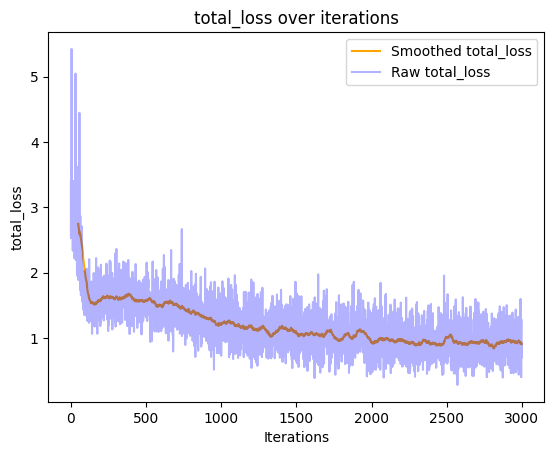

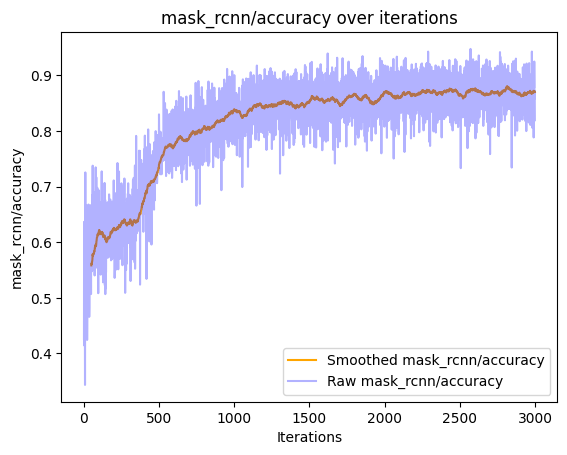

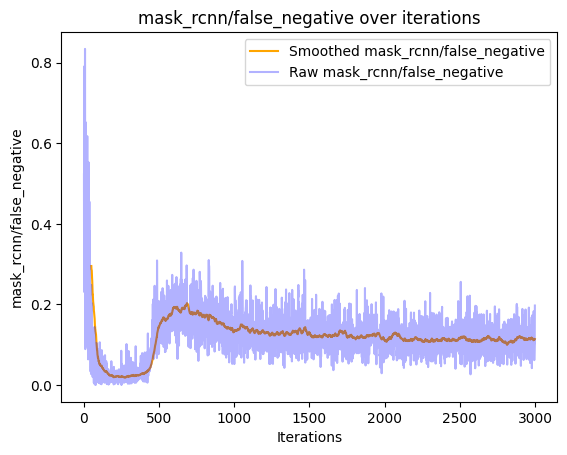

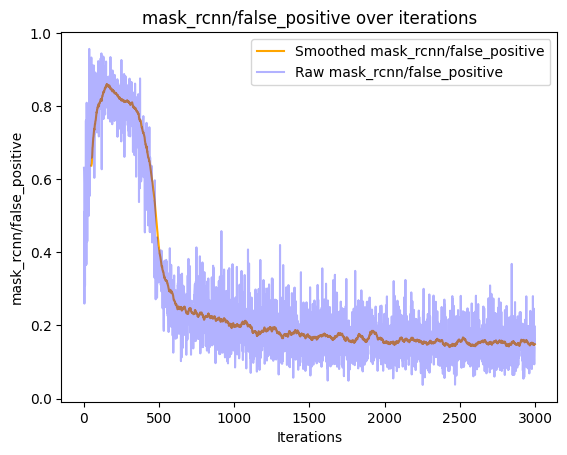

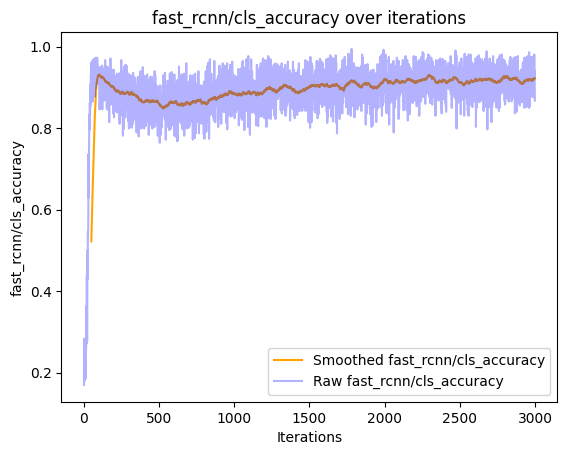

In [13]:
def plot_metric(metric_name):
    metrics = []
    iters = []

    for event in trainer.storage.history(metric_name).values():
        iters.append(event[1])
        metrics.append(event[0])

    window = 50
    smooth_metric = np.convolve(metrics, np.ones(window)/window, mode='valid')

    plt.plot(iters[window-1:], smooth_metric, label=f"Smoothed {metric_name}", color="orange")
    plt.plot(iters, metrics, alpha=0.3, label=f"Raw {metric_name}", color="blue")
    plt.xlabel("Iterations")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} over iterations")
    plt.legend()
    plt.show()

print(trainer.storage.histories().keys())

plot_metric("total_loss")
plot_metric("mask_rcnn/accuracy")
plot_metric("mask_rcnn/false_negative")
plot_metric("mask_rcnn/false_positive")
plot_metric("fast_rcnn/cls_accuracy")

Visualize model inference

[09/13 03:35:09 d2.data.datasets.coco]: Loaded 152 images in COCO format from /content/drive/MyDrive/Colab Notebooks/Dental Caries Lesion Stages/caries-dataset/test/_annotations_clean.coco.json


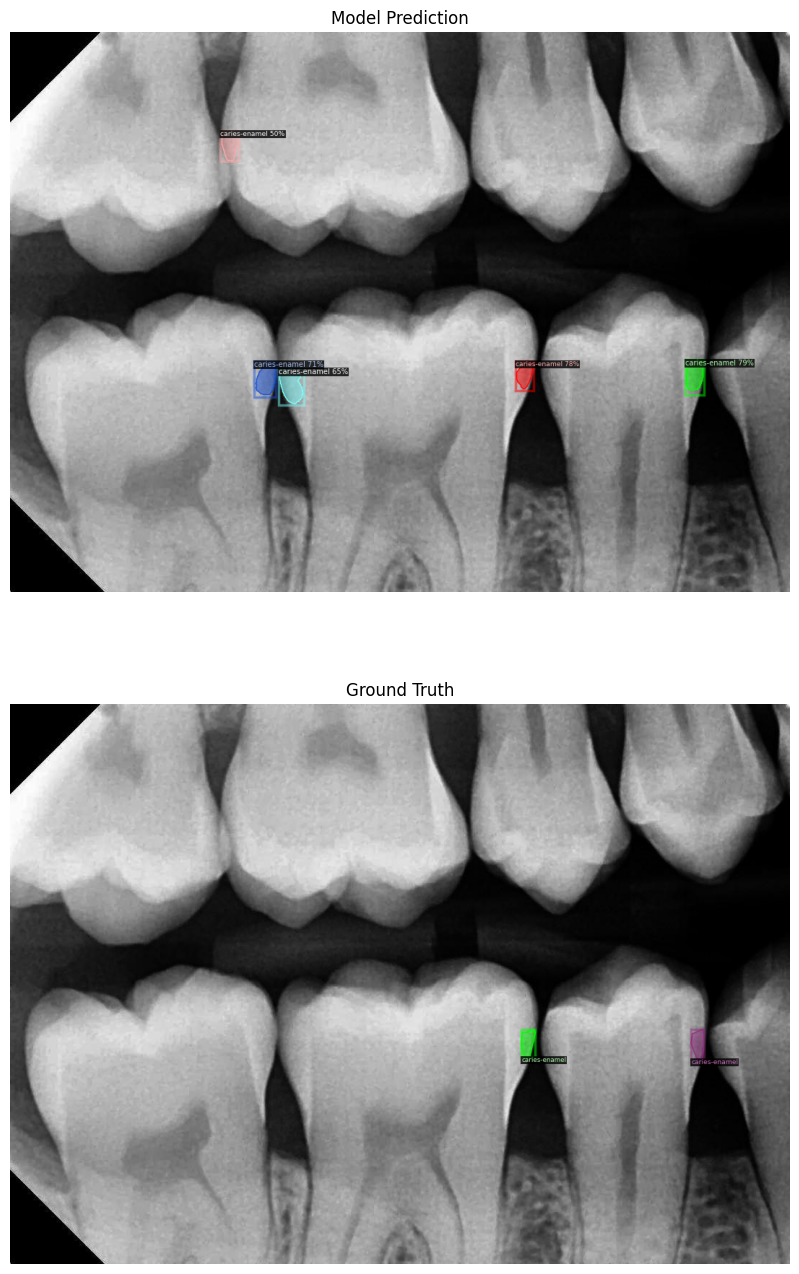

In [20]:
model = trainer.model
model.eval()

test_data = DatasetCatalog.get("test")
test_meta = MetadataCatalog.get("test")
img_dict = random.choice(test_data)
img = cv2.imread(img_dict["file_name"])

with torch.no_grad():
    outputs = model([{"image": torch.as_tensor(img.transpose(2, 0, 1))}])

v_pred = Visualizer(img[:, :, ::-1], metadata=test_meta, scale=1.0)
instances = outputs[0]["instances"]
instances = instances[instances.scores > 0.5]
out_pred = v_pred.draw_instance_predictions(instances.to("cpu"))
pred_img = out_pred.get_image()[:, :, ::-1]

v_gt = Visualizer(img[:, :, ::-1], metadata=test_meta, scale=1.0)
out_gt = v_gt.draw_dataset_dict(img_dict)
gt_img = out_gt.get_image()[:, :, ::-1]

plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plt.imshow(pred_img)
plt.title("Model Prediction")
plt.axis("off")
plt.subplot(2, 1, 2)
plt.imshow(gt_img)
plt.title("Ground Truth")
plt.axis("off")
plt.show()